### **Importing Libraries**

In [ ]:
import math
import random
from collections import defaultdict
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
import copy
from Card_and_Deck import *
from GameState import GameState
from Game_and_Player import *
import time

import networkx as nx
import matplotlib.pyplot as plt

### **Helper Functions**

In [ ]:
class MCTSNode:
    node_counter = 0
    def __init__(self, game_state, parent=None,move_taken=None,owner=None):
        self.game_state = game_state  # The game state at tho;his node
        self.parent = parent  # Parent node
        self.children = []  # List of child nodes
        self.visits = 1  # Number of times this node has been visited
        self.total_reward = 0  # Total reward (win/loss)
        self.untried_moves = list(self.game_state.get_legal_moves())  # Legal moves from this state
        self.move_taken = move_taken # move that led to this game state
        self.visited_nodes = {}
        self.owner=owner

    def expand(self,move):
          if move not in self.untried_moves:
            print(f"Warning: Move {move} not found in untried_moves!")
            print(f"Current untried_moves: {self.untried_moves}")
            return None
          game_state = self.game_state
          new_game_state = copy.deepcopy(game_state)
          self.untried_moves.remove(move)
          node_owner = self.game_state.players[self.game_state.current_player_index].name
          child_game_state = new_game_state.apply_move(move)

          child_node = MCTSNode(child_game_state, parent=self, move_taken=move,owner= node_owner)
          self.children.append(child_node)

          return child_node


    def simulate(self, game_state,current_name):

          game_state_new = copy.deepcopy(game_state)

          while not game_state_new.is_terminal():
              legal_moves = game_state_new.get_legal_moves()
              if not legal_moves:
                  break
              move = random.choice(legal_moves)
              game_state_new.apply_move(move)

          rewards = {}

          for player in game_state_new.players:
              player_tricks = game_state_new.tricks_won[player.name]
              rewards[player.name] = player_tricks/10

          r={}

          reward1= rewards.get(current_name,0)
          for player in game_state_new.players:
              if player.name != current_name:
                  r[player.name] = -reward1

          r[current_name] = reward1



          return r


    def backpropagate(self, rewards):

          self.visits += 1

          if self.owner:
              reward = rewards.get(self.owner, 0)
              self.total_reward += reward

          if self.parent:
              self.parent.backpropagate(rewards)


    def ucb1(self,child, c=0.707):

        parent_visits = child.parent.visits

        if child.visits == 0:
            return float("inf")
        ucb_val= (child.total_reward / child.visits) + c * math.sqrt(2*math.log(parent_visits) / child.visits)

        return ucb_val


    def best_child(self, c=4):
        node = self
        if not self.children:
            print("No children found! Returning None.")
            return None
        best = max(node.children, key=lambda child: node.ucb1(child, c))
        return best



    def tree_policy(self, c=1.4):
          current_node = self
          depth = 0

          while not current_node.game_state.is_terminal():
              if current_node.untried_moves:
                  move = random.choice(current_node.untried_moves)
                  return current_node
              else:
                  current_node = current_node.best_child(c)  # v ← BESTCHILD(v, Cp)
                  depth += 1

          return current_node



In [ ]:

def mcts_search(root_node, num_simulations=100,c=0.5):

    game_state_new = root_node.game_state
    root = root_node
    current_name = root_node.game_state.players[root_node.game_state.current_player_index].name

    for _ in range(num_simulations):
        node = root
        root.visits += 1

        # Tree Traversal
        node = node.tree_policy(c)


        # Expansion
        if node.untried_moves:
            move = random.choice(node.untried_moves)
            node = node.expand(move)


        # Simulation
        reward = node.simulate(node.game_state,current_name)

        # Backpropagation
        node.backpropagate(reward)


    best_child = max(root_node.children, key=lambda child: child.total_reward / (child.visits + 1e-6))
    return best_child.move_taken


## **Random Play Vs Monte Carlo**

In [ ]:
def evaluate_monte_carlo(num_games=1000, num_simulations=1000,c=0.5,verbose=False):
    monte_carlo_wins = 0
    win_results = []

    for _ in range(num_games):

        player_names = ["Alice", "Bob", "Charlie"]
        roles = ["Teen", "Do", "Paanch"]
        index = [0, 1, 2]



        game = Game(player_names, roles, index)
        game_state = GameState(game)

        game_state.current_player_index=random.choice(index)
        monte_carlo_player = random.choice(index)
        if verbose:
            print(f"Monte Carlo Player:{monte_carlo_player}")

        while not game_state.is_terminal():
            if game_state.current_player_index == monte_carlo_player:
                root_node = MCTSNode(game_state)
                best_move = mcts_search(root_node, num_simulations,c)


            else:
                legal_moves1 = game_state.get_legal_moves()
                best_move = random.choice(legal_moves1)
            game_state.apply_move(best_move)
            # print(f"Applied move:{best_move}")
            # print(f"Table Cards:{game_state.table_cards}")

        rewards = game_state.tricks_won

        if verbose:
            print(rewards)

        max_tricks = max(rewards.values())
        potential_winners = [name for name, count in rewards.items() if count == max_tricks]

        winner_name = potential_winners[0]
        monte_carlo_name = player_names[monte_carlo_player]



        if winner_name == monte_carlo_name:
            monte_carlo_wins += 1
            win_results.append(1)
            if verbose:
                print(f"Monte Carlo player won: {winner_name} ")
        else:
            win_results.append(0)
            if verbose:
                print(f"Monte Carlo player did not win: {winner_name} ")

    win_rate = monte_carlo_wins / num_games
    std_dev = np.std(win_results, ddof=1)

    print(f"Monte Carlo vs Random Win Rate: {win_rate:.2%}")
    print(f"Standard Deviation of Wins: {std_dev:.4f}")
    return win_rate



### **Testing different values of exploration constant**

In [ ]:
c_values = [0.1, 0.3,0.5,0.7, 0.8,0.9, 1.0,1.2, 1.5,1.7, 2.0]

results = []
times = []

for c in c_values:
    print(f"\nTesting with c = {c}")
    start = time.time()
    win_rate = evaluate_monte_carlo(num_games=100, num_simulations=100, c=c,verbose=False)
    end = time.time()

    elapsed_time = end - start
    results.append(win_rate)
    times.append(elapsed_time)

    print(f"Win Rate: {win_rate:.4f}")
    print(f"Execution Time: {elapsed_time:.4f} seconds")




Testing with c = 0.1
Monte Carlo vs Random Win Rate: 63.00%
Standard Deviation of Wins: 0.4852
Win Rate: 0.6300
Execution Time: 59.9699 seconds

Testing with c = 0.3
Monte Carlo vs Random Win Rate: 69.00%
Standard Deviation of Wins: 0.4648
Win Rate: 0.6900
Execution Time: 66.6391 seconds

Testing with c = 0.5
Monte Carlo vs Random Win Rate: 56.00%
Standard Deviation of Wins: 0.4989
Win Rate: 0.5600
Execution Time: 66.6832 seconds

Testing with c = 0.7
Monte Carlo vs Random Win Rate: 65.00%
Standard Deviation of Wins: 0.4794
Win Rate: 0.6500
Execution Time: 63.9451 seconds

Testing with c = 0.8
Monte Carlo vs Random Win Rate: 51.00%
Standard Deviation of Wins: 0.5024
Win Rate: 0.5100
Execution Time: 64.0567 seconds

Testing with c = 0.9
Monte Carlo vs Random Win Rate: 52.00%
Standard Deviation of Wins: 0.5021
Win Rate: 0.5200
Execution Time: 63.0806 seconds

Testing with c = 1.0
Monte Carlo vs Random Win Rate: 53.00%
Standard Deviation of Wins: 0.5016
Win Rate: 0.5300
Execution Time: 6

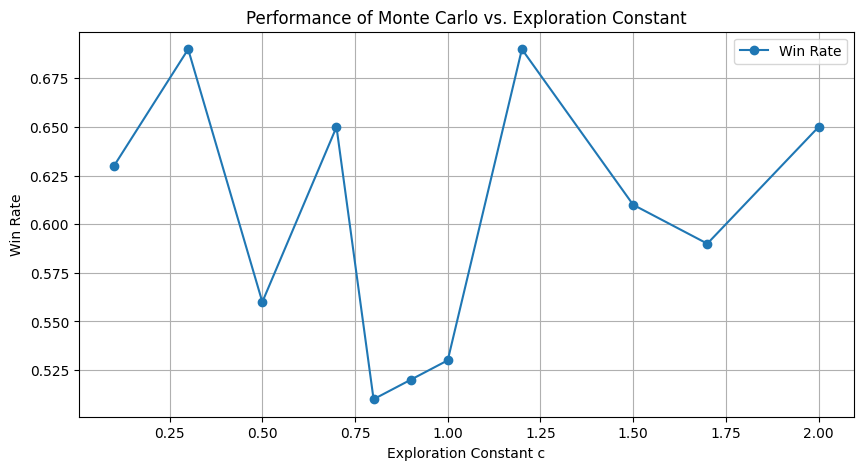

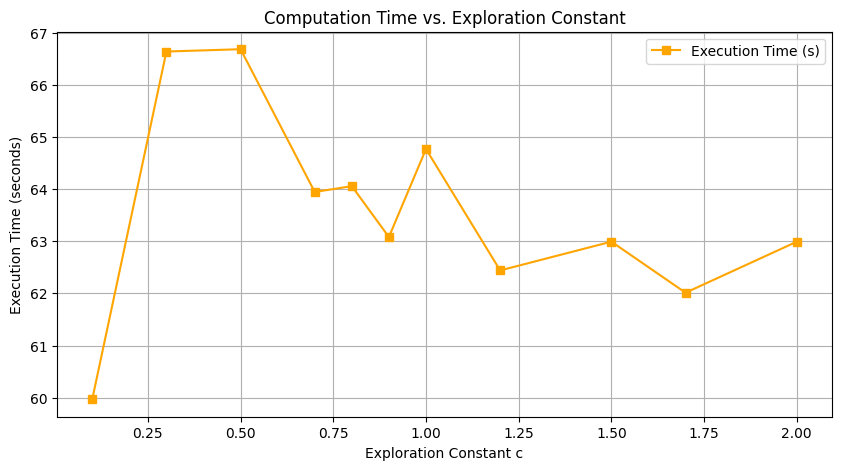

In [ ]:
# Win rate vs c
plt.figure(figsize=(10, 5))
plt.plot(c_values, results, marker='o', label='Win Rate')
plt.xlabel('Exploration Constant c')
plt.ylabel('Win Rate')
plt.title('Performance of Monte Carlo vs. Exploration Constant')
plt.grid(True)
plt.legend()
plt.show()

# Execution time vs c
plt.figure(figsize=(10, 5))
plt.plot(c_values, times, marker='s', color='orange', label='Execution Time (s)')
plt.xlabel('Exploration Constant c')
plt.ylabel('Execution Time (seconds)')
plt.title('Computation Time vs. Exploration Constant')
plt.grid(True)
plt.legend()
plt.show()


### **Testing for 500 games**

In [ ]:
start = time.time()
win_rate = evaluate_monte_carlo(num_games=500, num_simulations=100, c=1.2,verbose=True)
end = time.time()
elapsed_time = end - start
print(f"Execution Time: {elapsed_time:.4f} seconds")


Monte Carlo Player:0
{'Alice': 5, 'Bob': 3, 'Charlie': 2}
Monte Carlo player won: Alice 
Monte Carlo Player:1
{'Alice': 3, 'Bob': 4, 'Charlie': 3}
Monte Carlo player won: Bob 
Monte Carlo Player:0
{'Alice': 3, 'Bob': 0, 'Charlie': 7}
Monte Carlo player did not win: Charlie 
Monte Carlo Player:2
{'Alice': 2, 'Bob': 1, 'Charlie': 7}
Monte Carlo player won: Charlie 
Monte Carlo Player:2
{'Alice': 2, 'Bob': 2, 'Charlie': 6}
Monte Carlo player won: Charlie 
Monte Carlo Player:0
{'Alice': 5, 'Bob': 2, 'Charlie': 3}
Monte Carlo player won: Alice 
Monte Carlo Player:0
{'Alice': 3, 'Bob': 3, 'Charlie': 4}
Monte Carlo player did not win: Charlie 
Monte Carlo Player:1
{'Alice': 1, 'Bob': 4, 'Charlie': 5}
Monte Carlo player did not win: Charlie 
Monte Carlo Player:0
{'Alice': 4, 'Bob': 4, 'Charlie': 2}
Monte Carlo player won: Alice 
Monte Carlo Player:2
{'Alice': 3, 'Bob': 3, 'Charlie': 4}
Monte Carlo player won: Charlie 
Monte Carlo Player:2
{'Alice': 0, 'Bob': 7, 'Charlie': 3}
Monte Carlo player

## **Rule Based Play Vs Monte Carlo**

In [ ]:
def rule_based_move(game_state):
    legal_moves = game_state.get_legal_moves()
    return max(legal_moves, key=lambda card: card.rank)


def evaluate_monte_carlo(num_games=1000, num_simulations=1000,c=0.707):
    monte_carlo_wins = 0
    win_results = []

    for _ in range(num_games):

        player_names = ["Alice", "Bob", "Charlie"]
        roles = ["Teen", "Do", "Paanch"]
        index = [0, 1, 2]



        game = Game(player_names, roles, index)
        game_state = GameState(game)

        game_state.current_player_index=random.choice(index)
        monte_carlo_player = random.choice(index)
        print(f"Monte Carlo Player:{monte_carlo_player}")


        while not game_state.is_terminal():

            if game_state.current_player_index == monte_carlo_player:  # Monte Carlo player is Player 0
                root_node = MCTSNode(game_state)
                best_move = mcts_search(root_node, num_simulations,c)
            else:
                legal_moves = game_state.get_legal_moves()
                best_move = rule_based_move(game_state)

                if not legal_moves:
                    print(f"No legal moves for player {game_state.current_player_index}. Ending game.")
                    break



            game_state.apply_move(best_move)


        rewards = game_state.tricks_won
        print(rewards)
        max_tricks = max(rewards.values())
        potential_winners = [name for name, count in rewards.items() if count == max_tricks]

        winner_name = potential_winners[0]
        monte_carlo_name = player_names[monte_carlo_player]



        if winner_name == monte_carlo_name:
            monte_carlo_wins += 1
            win_results.append(1)
            print(f"Monte Carlo player won: {winner_name} ")
        else:
            win_results.append(0)
            print(f"Monte Carlo player did not win: {winner_name} ")

    win_rate = monte_carlo_wins / num_games
    std_dev = np.std(win_results, ddof=1)

    print(f"Monte Carlo vs Rule Based Win Rate: {win_rate:.2%}")
    print(f"Standard Deviation of Wins: {std_dev:.4f}")




In [ ]:
start=time.time()
evaluate_monte_carlo(num_games=500, num_simulations=100,c=np.sqrt(1/2))
end=time.time()
print(f"Execution Time: {end - start:.4f} seconds")

Monte Carlo Player:2
{'Alice': 5, 'Bob': 3, 'Charlie': 2}
Monte Carlo player did not win: Alice 
Monte Carlo Player:0
{'Alice': 4, 'Bob': 2, 'Charlie': 4}
Monte Carlo player won: Alice 
Monte Carlo Player:1
{'Alice': 6, 'Bob': 3, 'Charlie': 1}
Monte Carlo player did not win: Alice 
Monte Carlo Player:2
{'Alice': 1, 'Bob': 3, 'Charlie': 6}
Monte Carlo player won: Charlie 
Monte Carlo Player:0
{'Alice': 4, 'Bob': 1, 'Charlie': 5}
Monte Carlo player did not win: Charlie 
Monte Carlo Player:1
{'Alice': 3, 'Bob': 4, 'Charlie': 3}
Monte Carlo player won: Bob 
Monte Carlo Player:2
{'Alice': 3, 'Bob': 3, 'Charlie': 4}
Monte Carlo player won: Charlie 
Monte Carlo Player:1
{'Alice': 1, 'Bob': 5, 'Charlie': 4}
Monte Carlo player won: Bob 
Monte Carlo Player:2
{'Alice': 3, 'Bob': 2, 'Charlie': 5}
Monte Carlo player won: Charlie 
Monte Carlo Player:0
{'Alice': 5, 'Bob': 0, 'Charlie': 5}
Monte Carlo player won: Alice 
Monte Carlo Player:1
{'Alice': 2, 'Bob': 4, 'Charlie': 4}
Monte Carlo player won: 